In [1]:
import numpy as np
import itertools
import pandas as pd
from scipy.stats import multivariate_normal, norm
import gurobipy as gp
from gurobipy import GRB
from IPython.display import display, Math
from gurobipy import GRB, quicksum
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from itertools import product, combinations

## Concepts Learning

##### 2.1 Problem Setup and Weighting Framework

Calculate the true factorial effect of both main effect and interaction effect in the simulation

In [ ]:
np.random.seed(42)
# Set up the parameters
K = 3  # Number of binary factors
Q = 2 ** K  # Number of possible treatment combinations
N = 1000  # Number of subjects

# Generate all possible treatment combinations
treatment_combinations = np.array(list(itertools.product([-1, 1], repeat=K)))

# Simulate covariates X (D-dimensional, here D=3 for simplicity)
D = 3
X = np.random.normal(0, 1, size=(N, D))

# Simulate potential outcomes for each individual and each treatment combination
# Assume potential outcomes depend on treatment and covariates linearly
beta_treatment = np.random.randn(Q)  # Random effect size for each treatment combination
beta_covariate = np.random.randn(D)  # Effect size for covariates

# For each subject, generate potential outcomes
Y_potential = np.zeros((N, Q))
for i in range(N):
    for q in range(Q):
        Y_potential[i, q] = beta_treatment[q] + X[i].dot(beta_covariate) + np.random.normal(0, 1)

# Assign each individual a random treatment from the possible combinations
Z_indices = np.random.choice(Q, size=N)  # Random treatment assignment
Y_observed = np.array([Y_potential[i, Z_indices[i]] for i in range(N)])  # Observed outcome

# Estimate main effects
# Contrast vector for each factor
# arms = list(itertools.product([0,1], repeat=K))
# g_factor1 = []
# for z in arms:
#     if z[0] == 1:
#         g_factor1.append( +1.0 )
#     else:
#         g_factor1.append( -1.0 )
# g_factor1 = np.array(g_factor1)

main_effects = []
for k in range(K):
    g_k = np.array([1 if comb[k] == 1 else -1 for comb in treatment_combinations])
    E_Y = np.array([np.mean(Y_observed[Z_indices == q]) if np.any(Z_indices == q) else 0 for q in range(Q)])
    tau_k = (1 / (2 ** (K - 1))) * g_k.T @ E_Y
    main_effects.append(tau_k)

# Estimate interaction effects between two factors
interaction_effects = {}
for k1, k2 in itertools.combinations(range(K), 2):
    g_k1 = np.array([1 if comb[k1] == 1 else -1 for comb in treatment_combinations])
    g_k2 = np.array([1 if comb[k2] == 1 else -1 for comb in treatment_combinations])
    g_interaction = g_k1 * g_k2
    tau_k1k2 = (1 / (2 ** (K - 1))) * g_interaction @ E_Y
    interaction_effects[(k1, k2)] = tau_k1k2

# Present results
results = {
    "Main Effects": main_effects,
    "Interaction Effects": interaction_effects
}

# Convert results to DataFrame for display
main_effects_df = pd.DataFrame({
    'Factor': [f'z_{k+1}' for k in range(K)],
    'Estimated Main Effect': main_effects
})

interaction_effects_df = pd.DataFrame(
    [(f'z_{k1+1} & z_{k2+1}', effect) for (k1, k2), effect in interaction_effects.items()],
    columns=['Interaction', 'Estimated Effect']
)

# Display the DataFrames using standard methods
print("Main Effects Estimates:\n")
print(main_effects_df)

print("\nInteraction Effects Estimates:\n")
print(interaction_effects_df)


Main Effects Estimates:

  Factor  Estimated Main Effect
0    z_1              -0.161658
1    z_2               1.055239
2    z_3              -0.132745

Interaction Effects Estimates:

  Interaction  Estimated Effect
0   z_1 & z_2         -1.158903
1   z_1 & z_3         -1.797397
2   z_2 & z_3          0.317097


##### 2.2 Weighting for Observational Factorial Studies

Calculate the estimated factorial effect tau_hat in observational factorial study by applying a weighting function

In [131]:

# Simulate f(X) and f_z(X) for weighting function
# Assume f(X) is standard normal and f_z(X) shifts mean for treatment groups
f_X = norm.pdf(X)
f_z = np.zeros(N)
for i in range(N):
    z_idx = Z_indices[i]
    treatment_effect = treatment_combinations[z_idx]
    shifted_mean = treatment_effect * 0.5  # Shifted by treatment effect
    f_z[i] = np.prod(norm.pdf(X[i], loc=shifted_mean, scale=1))

# Weighting function w_z(X) = f(X) / f_z(X)
w_z = np.prod(f_X, axis=1) / f_z
w_i = N * w_z / (2 ** (K - 1) * np.bincount(Z_indices, minlength=Q)[Z_indices])

# Calculate the weighting estimator for factorial effects
weighted_effects = []
for k in range(K):
    g_k = np.array([1 if comb[k] == 1 else -1 for comb in treatment_combinations])
    g_k_pos = np.maximum(g_k, 0)
    g_k_neg = np.maximum(-g_k, 0)

    # A_iK^+ and A_iK^-
    A_iK_pos = np.array([np.sum([g_k_pos[q] * (Z_indices[i] == q) for q in range(Q)]) for i in range(N)])
    A_iK_neg = 1 - A_iK_pos

    # Weighted estimators for tau_K^+ and tau_K^-
    tau_k_pos = (1 / N) * np.sum(w_i * A_iK_pos * Y_observed)
    tau_k_neg = (1 / N) * np.sum(w_i * A_iK_neg * Y_observed)

    # Combine to get the weighted factorial effect
    tau_k_weighted = tau_k_pos - tau_k_neg
    weighted_effects.append(tau_k_weighted)

# Interaction effects using the weighting estimator
interaction_effects_weighted = {}
for k1, k2 in itertools.combinations(range(K), 2):
    g_k1 = np.array([1 if comb[k1] == 1 else -1 for comb in treatment_combinations])
    g_k2 = np.array([1 if comb[k2] == 1 else -1 for comb in treatment_combinations])
    g_interaction = g_k1 * g_k2

    g_interaction_pos = np.maximum(g_interaction, 0)
    g_interaction_neg = np.maximum(-g_interaction, 0)

    A_iK_pos = np.array([np.sum([g_interaction_pos[q] * (Z_indices[i] == q) for q in range(Q)]) for i in range(N)])
    A_iK_neg = 1 - A_iK_pos

    tau_inter_pos = (1 / N) * np.sum(w_i * A_iK_pos * Y_observed)
    tau_inter_neg = (1 / N) * np.sum(w_i * A_iK_neg * Y_observed)

    tau_inter_weighted = tau_inter_pos - tau_inter_neg
    interaction_effects_weighted[(k1, k2)] = tau_inter_weighted

# Prepare results
weighted_main_effects_df = pd.DataFrame({
    'Factor': [f'z_{k+1}' for k in range(K)],
    'Weighted Effect': weighted_effects
})

weighted_interaction_effects_df = pd.DataFrame(
    [(f'z_{k1+1} & z_{k2+1}', effect) for (k1, k2), effect in interaction_effects_weighted.items()],
    columns=['Interaction', 'Weighted Effect']
)

# Display results
print("Weighted Main Effects Using Weighting Estimator:\n", weighted_main_effects_df)
print("\nWeighted Interaction Effects Using Weighting Estimator:\n", weighted_interaction_effects_df)


Weighted Main Effects Using Weighting Estimator:
   Factor  Weighted Effect
0    z_1        -2.987851
1    z_2         4.016794
2    z_3         0.297760

Weighted Interaction Effects Using Weighting Estimator:
   Interaction  Weighted Effect
0   z_1 & z_2        -1.370218
1   z_1 & z_3        -3.425903
2   z_2 & z_3         0.728277


#### 3.1 Weighting for Estimating a Single Factorial Effect 

##### 3.1.1 General Additive Outcome Model

The model assumes outcomes are affected by both covariates and factorial interactions.

The weighting balances both: Covariates across treatment assignments and Higher-order interactions that can bias the factorial effect estimation.

In [132]:

# Parameters
K = 3  # Number of binary factors
Q = 2 ** K  # Number of treatment combinations
N = 1000  # Number of individuals

# Generate treatment combinations
treatment_combinations = np.array(list(itertools.product([-1, 1], repeat=K)))

# Simulate covariates X (D-dimensional)
D = 3
X = np.random.normal(0, 1, size=(N, D))

# Simulate potential outcomes using a general additive model
S = 3  # Number of basis functions
alpha = np.random.randn(S)
beta = np.random.randn(Q)

# Define basis functions h_s(X) = X^s (simple polynomial basis)
def h_s(X, s):
    return X ** (s + 1)

# Compute mu(X) and nu(z)
mu_X = np.sum([alpha[s] * h_s(X, s).sum(axis=1) for s in range(S)], axis=0)
nu_z = np.zeros((N, Q))
for i in range(N):
    for q in range(Q):
        z = treatment_combinations[q]
        nu_z[i, q] = beta[q] * np.prod(z)

# Simulate potential outcomes with reshaping for broadcasting
Y_potential = mu_X[:, np.newaxis] + nu_z + np.random.normal(0, 1, size=(N, Q))


# Random assignment of treatments
Z_indices = np.random.choice(Q, size=N)
Y_observed = np.array([Y_potential[i, Z_indices[i]] for i in range(N)])

# Simulate f(X) and f_z(X) for weighting
f_X = norm.pdf(X)
f_z = np.zeros(N)
for i in range(N):
    z_idx = Z_indices[i]
    treatment_effect = treatment_combinations[z_idx]
    shifted_mean = treatment_effect * 0.5
    f_z[i] = np.prod(norm.pdf(X[i], loc=shifted_mean, scale=1))

# Weighting function
w_z = np.prod(f_X, axis=1) / f_z
w_i = N * w_z / (2 ** (K - 1) * np.bincount(Z_indices, minlength=Q)[Z_indices])

# Calculate the new weighting estimator
weighted_effects = []
for k in range(K):
    g_k = np.array([1 if comb[k] == 1 else -1 for comb in treatment_combinations])
    g_k_pos = np.maximum(g_k, 0)
    g_k_neg = np.maximum(-g_k, 0)

    # A_iK^+ and A_iK^-
    A_iK_pos = np.array([np.sum([g_k_pos[q] * (Z_indices[i] == q) for q in range(Q)]) for i in range(N)])
    A_iK_neg = 1 - A_iK_pos

    # Weighted estimators for tau_K^+ and tau_K^-
    tau_k_pos = (1 / N) * np.sum(w_i * A_iK_pos * Y_observed)
    tau_k_neg = (1 / N) * np.sum(w_i * A_iK_neg * Y_observed)

    # Combine to get the weighted factorial effect
    tau_k_weighted = tau_k_pos - tau_k_neg
    weighted_effects.append(tau_k_weighted)

# Interaction effects using the new weighting estimator
interaction_effects_weighted = {}
for k1, k2 in itertools.combinations(range(K), 2):
    g_k1 = np.array([1 if comb[k1] == 1 else -1 for comb in treatment_combinations])
    g_k2 = np.array([1 if comb[k2] == 1 else -1 for comb in treatment_combinations])
    g_interaction = g_k1 * g_k2

    g_interaction_pos = np.maximum(g_interaction, 0)
    g_interaction_neg = np.maximum(-g_interaction, 0)

    A_iK_pos = np.array([np.sum([g_interaction_pos[q] * (Z_indices[i] == q) for q in range(Q)]) for i in range(N)])
    A_iK_neg = 1 - A_iK_pos

    tau_inter_pos = (1 / N) * np.sum(w_i * A_iK_pos * Y_observed)
    tau_inter_neg = (1 / N) * np.sum(w_i * A_iK_neg * Y_observed)

    tau_inter_weighted = tau_inter_pos - tau_inter_neg
    interaction_effects_weighted[(k1, k2)] = tau_inter_weighted

# Prepare results
weighted_main_effects_df = pd.DataFrame({
    'Factor': [f'z_{k+1}' for k in range(K)],
    'Weighted Effect': weighted_effects
})

weighted_interaction_effects_df = pd.DataFrame(
    [(f'z_{k1+1} & z_{k2+1}', effect) for (k1, k2), effect in interaction_effects_weighted.items()],
    columns=['Interaction', 'Weighted Effect']
)

# Display results
print("Weighted Main Effects Using New Weighting Estimator:\n", weighted_main_effects_df)
print("\nWeighted Interaction Effects Using New Weighting Estimator:\n", weighted_interaction_effects_df)


Weighted Main Effects Using New Weighting Estimator:
   Factor  Weighted Effect
0    z_1       -24.132946
1    z_2       -23.197599
2    z_3       -31.894444

Weighted Interaction Effects Using New Weighting Estimator:
   Interaction  Weighted Effect
0   z_1 & z_2       -12.284402
1   z_1 & z_3        -1.435613
2   z_2 & z_3       -12.994322


##### 3.1.2 Outcome Model with Treatment Effect Heterogeneity

In [133]:
# Parameters
K = 3  # Number of binary factors
Q = 2 ** K  # Number of treatment combinations
N = 1000  # Number of individuals

# Generate treatment combinations
treatment_combinations = np.array(list(itertools.product([-1, 1], repeat=K)))

# Simulate covariates X (D-dimensional)
D = 3
X = np.random.normal(0, 1, size=(N, D))

# Simulate potential outcomes using heterogeneous treatment effects
S = 3  # Number of basis functions
alpha = np.random.randn(S, Q)  # Different coefficients for each treatment
beta = np.random.randn(Q)

# Define basis functions h_s(X) = X^s (polynomial basis)
def h_s(X, s):
    return X ** (s + 1)

# Define heterogeneous basis functions q_sJ(X, z)
def q_sJ(X, z, s):
    return h_s(X, s) * np.prod(z)

# Compute mu(X, z) with heterogeneity
mu_XZ = np.zeros((N, Q))
for i in range(N):
    for q in range(Q):
        z = treatment_combinations[q]
        mu_XZ[i, q] = sum([alpha[s, q] * h_s(X[i], s).sum() for s in range(S)])

# Simulate nu(z)
nu_z = np.zeros((N, Q))
for i in range(N):
    for q in range(Q):
        z = treatment_combinations[q]
        nu_z[i, q] = beta[q] * np.prod(z)

# Generate potential outcomes
Y_potential = mu_XZ + nu_z + np.random.normal(0, 1, size=(N, Q))

# Random assignment of treatments
Z_indices = np.random.choice(Q, size=N)
Y_observed = np.array([Y_potential[i, Z_indices[i]] for i in range(N)])

# Simulate f(X) and f_z(X) for weighting function
f_X = norm.pdf(X)
f_z = np.zeros(N)
for i in range(N):
    z_idx = Z_indices[i]
    treatment_effect = treatment_combinations[z_idx]
    shifted_mean = treatment_effect * 0.5
    f_z[i] = np.prod(norm.pdf(X[i], loc=shifted_mean, scale=1))

# Weighting function
w_z = np.prod(f_X, axis=1) / f_z
w_i = N * w_z / (2 ** (K - 1) * np.bincount(Z_indices, minlength=Q)[Z_indices])

# Calculate the weighting estimator with heterogeneity
weighted_effects = []
for k in range(K):
    g_k = np.array([1 if comb[k] == 1 else -1 for comb in treatment_combinations])
    g_k_pos = np.maximum(g_k, 0)
    g_k_neg = np.maximum(-g_k, 0)

    # A_iK^+ and A_iK^-
    A_iK_pos = np.array([np.sum([g_k_pos[q] * (Z_indices[i] == q) for q in range(Q)]) for i in range(N)])
    A_iK_neg = 1 - A_iK_pos

    # Weighted estimators for tau_K^+ and tau_K^-
    tau_k_pos = (1 / N) * np.sum(w_i * A_iK_pos * Y_observed)
    tau_k_neg = (1 / N) * np.sum(w_i * A_iK_neg * Y_observed)

    # Combine to get the weighted factorial effect
    tau_k_weighted = tau_k_pos - tau_k_neg
    weighted_effects.append(tau_k_weighted)

# Interaction effects with heterogeneity
interaction_effects_weighted = {}
for k1, k2 in itertools.combinations(range(K), 2):
    g_k1 = np.array([1 if comb[k1] == 1 else -1 for comb in treatment_combinations])
    g_k2 = np.array([1 if comb[k2] == 1 else -1 for comb in treatment_combinations])
    g_interaction = g_k1 * g_k2

    g_interaction_pos = np.maximum(g_interaction, 0)
    g_interaction_neg = np.maximum(-g_interaction, 0)

    A_iK_pos = np.array([np.sum([g_interaction_pos[q] * (Z_indices[i] == q) for q in range(Q)]) for i in range(N)])
    A_iK_neg = 1 - A_iK_pos

    tau_inter_pos = (1 / N) * np.sum(w_i * A_iK_pos * Y_observed)
    tau_inter_neg = (1 / N) * np.sum(w_i * A_iK_neg * Y_observed)

    tau_inter_weighted = tau_inter_pos - tau_inter_neg
    interaction_effects_weighted[(k1, k2)] = tau_inter_weighted

# Prepare results
weighted_main_effects_df = pd.DataFrame({
    'Factor': [f'z_{k+1}' for k in range(K)],
    'Weighted Effect': weighted_effects
})

weighted_interaction_effects_df = pd.DataFrame(
    [(f'z_{k1+1} & z_{k2+1}', effect) for (k1, k2), effect in interaction_effects_weighted.items()],
    columns=['Interaction', 'Weighted Effect']
)

# Display results
print("Weighted Main Effects with Heterogeneity:\n", weighted_main_effects_df)
print("\nWeighted Interaction Effects with Heterogeneity:\n", weighted_interaction_effects_df)


Weighted Main Effects with Heterogeneity:
   Factor  Weighted Effect
0    z_1         0.482502
1    z_2        -5.983616
2    z_3         6.097514

Weighted Interaction Effects with Heterogeneity:
   Interaction  Weighted Effect
0   z_1 & z_2        -1.208426
1   z_1 & z_3        -1.007165
2   z_2 & z_3         7.781101


#### Simulate the proposed weighting estimator using additive balance constraints under a general additive model. 
##### The proposed weighting estimator using balance constraints under the general additive model assumption (additive balance constraints) and covariate basis functions h𝑠(𝐗) = 𝑋𝑠, 𝑠 = 1, ... , 5, 

 I wrote the forms of the potential outcomes of Y1, Y2, Y3 based on the simulation setting in Section 5 and then calculate their expectations E[Y]. And then followed the Secontion 3.1.1 on he balance constrains we need to optimize using gurobi to minimize the weighting wi. 

The balance constrains are: 

$$
\sum_{i=1}^{N} w_i A_{i \kappa}^{\Omega} h_s(\mathbf{X}_i) = \sum_{i=1}^{N} h_s(\mathbf{X}_i), \quad \text{for } \Omega = +, - \text{ and } s = 1, \dots, S,
$$

And include the factors themselves and the non-negligible interactions as additional "covariates" for balancing such that

$$
\frac{1}{N} \sum_{i=1}^{N} w_i A_{i\kappa}^{\Omega} \prod_{j \in J} Z_{ij} = \frac{1}{2^{K-1}} \sum_{z \in \mathcal{Z}} g_{\kappa z}^{\Omega} \prod_{j \in J} z_j,  \text{ for } \Omega = +,- \text{ and } J \in [K]_{K'}.
$$



After optimization, extract the optimized weights and then first calculate the true factorial effects tau, which the formula is $$\tau_k = \frac{1}{2^{K-1}} \mathbf{g}_k^{\mathrm{T}} \mathbb{E}[\mathbf{Y}]$$ 

Then calculate the estimated weighted factorial effects tua_hat in the Section 2.2 where 


we need to assign a weight of $w_{Z_i}(\mathbf{X}_i)$ to the observed outcome of individual i, determined by the specific treatment combination they received.

Let $w_i = N w_{Z_i}(\mathbf{X}_i)/(2^{K-1} N_{Z_i})$ denote the normalized weights, and let


$$
A_{i\kappa}^{+} = \sum_{z \in \mathcal{Z}} g_{\kappa z}^{+} I(Z_i = z)
$$

$$
A_{i\kappa}^{-} = \sum_{z \in \mathcal{Z}} g_{\kappa z}^{-} I(Z_i = z) = 1 - A_{i\kappa}^{+} 
$$

denote whether individual i belongs to the positive or negative part of contrast $\mathbf{g}_\kappa$, respectively.


We estimate the factorial effect $\tau_\kappa$ with the weighting estimator:


$$
\hat{\tau}_\kappa = \hat{\tau}_\kappa^{+} - \hat{\tau}_\kappa^{-}, 
$$

$$
\text{where    }     \hat{\tau}_\kappa^{\Omega} = \frac{1}{N} \sum_{i=1}^{N} w_i A_{i\kappa}^{\Omega} Y_i^{\text{obs}}, \quad \text{for } \Omega = +, -.
$$

Lastly, calculte the RMSE which The RMSE is calculated as the square root of the average of (\hat\tau-\tau)^2.

In [12]:
np.random.seed(123)

# Step 1: Generate Xi from a multivariate normal distribution
def generate_covariates(N, mu, rho):
    K = len(mu)
    Sigma = rho * np.ones((K, K)) + (1 - rho) * np.eye(K)  # Covariance matrix
    X = multivariate_normal.rvs(mean=mu, cov=Sigma, size=N)
    return X

# Step 2: Generate 3 treatment assignments Zik based on logistic regression
def generate_treatment(X, betas):
    N = X.shape[0]
    K = len(betas)  # Number of factors
    Z = np.zeros((N, K))  # Initialize treatment matrix

    # Generate treatments independently for each factor
    for k in range(K):
        logits = X @ betas[k]  
        prob = 1 / (1 + np.exp(-logits)) 
        Z[:, k] = np.random.binomial(1, prob)  

    return Z

# Step 3: Simulate potential outcomes Yi1, Yi2, Yi3
def simulate_outcomes(X, Z):
    N = X.shape[0]
    epsilon1 = np.random.normal(0, 1, N)
    epsilon2 = np.random.normal(0, 1, N)
    epsilon3 = np.random.normal(0, 1, N)

    # Simulate outcomes based on the paper's specifications
    Y1 = 2 * np.sum(X, axis=1) + np.sum(Z, axis=1) + epsilon1
    interaction_term = np.sum(X[:, :3] * Z, axis=1)  # Interaction with first 3 covariates
    Y2 = 2 * np.sum(X, axis=1) + interaction_term + epsilon2
    Y3 = np.sin(X[:, 0]) + np.cos(X[:, 1]) + (np.minimum(1, X[:, 0]) + X[:, 1]) * Z[:, 0] + np.sum(X[:, :2] * Z[:, 1:3], axis=1) + epsilon3

    return Y1, Y2, Y3

# Step 4: Optimize weights using Gurobi with variance minimization
def solve_weights_additive(X, Z):
    N = X.shape[0]
    Aplus = np.where(Z>0, 1.0, 0.0)   # shape (N,K)
    Aminus= 1.0 - Aplus              # shape (N,K)

    sumX = np.sum(X, axis=0)  # shape (D,)

    model = gp.Model("AdditiveBalance")
    model.setParam('OutputFlag', 0)  # turn off solver chatter
    w_vars = model.addVars(N, vtype=GRB.CONTINUOUS, lb=0.0, name="w")

    # minimize sum_i w_i^2
    obj = gp.quicksum(w_vars[i]*w_vars[i] for i in range(N))
    model.setObjective(obj, GRB.MINIMIZE)

    for k_ in range(K):
        for d_ in range(5):
            lhs_plus  = gp.quicksum(w_vars[i]*Aplus[i,k_]*X[i,d_] for i in range(N))
            lhs_minus = gp.quicksum(w_vars[i]*Aminus[i,k_]*X[i,d_] for i in range(N))
            model.addConstr(lhs_plus  == sumX[d_])
            model.addConstr(lhs_minus == sumX[d_])

    for k_ in range(K):
        lhs_plus  = gp.quicksum(w_vars[i]*Aplus[i,k_]  for i in range(N))
        lhs_minus = gp.quicksum(w_vars[i]*Aminus[i,k_] for i in range(N))
        model.addConstr(lhs_plus  == N)
        model.addConstr(lhs_minus == N)

    model.optimize()
    if model.status != GRB.OPTIMAL:
        print("Model did not find an optimal solution!")
        return None

    w_opt = np.array([w_vars[i].X for i in range(N)])
    return w_opt

# Step 5: Calculate the true factorial main effects tau for each treatment factor
def calculate_tau(Y, Z, K):
    n_combinations = 2 ** K
    treatment_combinations = np.array([[int(x) for x in format(i, f'0{K}b')] for i in range(n_combinations)])
    Q = len(treatment_combinations)

    # Assign each individual to a treatment combination index
    Z_indices = np.array([int("".join(map(str, map(int, row))), 2) for row in Z.astype(int)])

    main_effects = []
    for k in range(K):  # For each treatment factor
        # Contrast vector for the kth factor
        g_k = np.array([1 if comb[k] == 1 else -1 for comb in treatment_combinations])

        # Calculate mean outcomes for each treatment combination
        E_Y = np.array([np.mean(Y[Z_indices == q]) if np.any(Z_indices == q) else 0 for q in range(Q)])

        # Calculate tau_k for each factor
        tau_k = (1 / (2 ** (K - 1))) * g_k.T @ E_Y
        main_effects.append(tau_k)

    return np.array(main_effects)

# Step 6: Calculate estimated factorial effects tau_hat for each treatment factor with weights
def calculate_tau_hat(Y, weights, Z, K):
    N = len(Y)
    Q = 2 ** K  # Number of treatment combinations
    weighted_effects = []

    # Generate all possible treatment combinations
    treatment_combinations = [list(map(int, bin(i)[2:].zfill(K))) for i in range(Q)]

    # Assign each individual to a treatment combination index
    Z_indices = np.array([int("".join(map(str, map(int, row))), 2) for row in Z.astype(int)])

    for k in range(K):
        # Create contrast vector specific to treatment factor k
        g_k = np.array([1 if comb[k] == 1 else -1 for comb in treatment_combinations])

        # Positive and negative contrasts
        g_k_pos = np.maximum(g_k, 0)
        g_k_neg = np.maximum(-g_k, 0)

        # A_iK^+ and A_iK^-
        A_iK_pos = np.array([np.sum([g_k_pos[q] * (Z_indices[i] == q) for q in range(Q)]) for i in range(N)])
        A_iK_neg = np.array([np.sum([g_k_neg[q] * (Z_indices[i] == q) for q in range(Q)]) for i in range(N)])

        # Weighted estimators for tau_K^+ and tau_K^-
        tau_k_pos = (1 / N) * np.sum(weights * A_iK_pos * Y)
        tau_k_neg = (1 / N) * np.sum(weights * A_iK_neg * Y)

        # Combine to get the weighted factorial effect
        tau_k_weighted = tau_k_pos - tau_k_neg
        weighted_effects.append(tau_k_weighted)

    return np.array(weighted_effects)

# Step 7: Calculate RMSE
def calculate_rmse(tau_hat, tau):
    return np.sqrt(np.mean((tau_hat - tau) ** 2))

# Step 8: Check covariate balance by calculating standardized mean differences (SMD)

In [13]:
np.random.seed(123)

N = 200
mu = np.array([0.1, 0.1, 0.1, 0, 0]).T  
rho = 0.0
repetitions = 100
beta1 = np.array([1/4, 2/4, 0, 3/4, 1])
beta2 = np.array([3/4, 1/4, 1, 0, 2/4])
beta3 = np.array([1, 0, 3/4, 2/4, 1/4])
betas = [beta1, beta2, beta3]
K = 3
outcome_results = np.zeros((3, repetitions, 2, K))

for rep in range(repetitions):
    X = generate_covariates(N, mu, rho)
    Z = generate_treatment(X, betas)
    Y1,Y2,Y3 = simulate_outcomes(X, Z)
    additive_weights = solve_weights_additive(X, Z)

    outcomes = [Y1, Y2, Y3]
    for idx, Y in enumerate(outcomes):
        tau_true = calculate_tau(Y, Z, K)
        tau_hat = calculate_tau_hat(Y, additive_weights, Z, K)
        rmse = calculate_rmse(tau_hat, tau_true)
        outcome_results[idx, rep, 1, :] = (tau_hat - tau_true) ** 2  # Squared error for RMSE calculation

average_rmse = np.sqrt(np.mean(outcome_results[:, :, 1, :], axis=1))

# Display results
model_names = ['Additive Outcome (Y1)', 'Heterogeneous Treatment Effect (Y2)', 'Misspecified Outcome (Y3)']
for idx, model in enumerate(model_names):
    print(f"\nModel: {model}")
    print(f"True factorial effects (tau): {tau_true}")
    print(f"Estimated factorial effects (tau_hat): {tau_hat}")
    print("Average RMSE for each factor:", average_rmse[idx])


Model: Additive Outcome (Y1)
True factorial effects (tau): [0.01396847 1.16763129 1.98262424]
Estimated factorial effects (tau_hat): [0.1677569  0.47021708 0.05490749]
Average RMSE for each factor: [3.24197949 2.95321142 2.81136676]

Model: Heterogeneous Treatment Effect (Y2)
True factorial effects (tau): [0.01396847 1.16763129 1.98262424]
Estimated factorial effects (tau_hat): [0.1677569  0.47021708 0.05490749]
Average RMSE for each factor: [3.28922289 3.44425362 3.07698247]

Model: Misspecified Outcome (Y3)
True factorial effects (tau): [0.01396847 1.16763129 1.98262424]
Estimated factorial effects (tau_hat): [0.1677569  0.47021708 0.05490749]
Average RMSE for each factor: [0.52313099 0.78042318 0.98123223]


#### Proposed Weighting Estimator with Treatment Effect Heterogeneity: Incorporates interaction balance constraints.

##### The proposed weighting estimator using balance constraints under the outcome model assumption with treatment effect het- erogeneity (interaction balance constraints) and the same set of basis functions as (iii)

I wrote the forms of the potential outcomes of Y1, Y2, Y3 based on the simulation setting in Section 5 and then calculate their expectations E[Y]. And then followed the Secontion 3.1.1 on he balance constrains we need to optimize using gurobi to minimize the weighting wi. After optimization, extract the optimized weights and then first calculate the true factorial effects tau, which the formula is $\tau_k = \frac{1}{2^{K-1}} \mathbf{g}_k^{\mathrm{T}} \mathbb{E}[\mathbf{Y}]$, then calculate the estimated weighted factorial effects tua_hat in the Section 2.2. Lastly, calculte the RMSE which The RMSE is calculated as the square root of the average of (\hat\tau-\tau)^2.

$$
\sum_{i=1}^{N} w_i A_{i \kappa}^{\Omega} \mathbf{q}(\mathbf{X}_i, \mathbf{Z}_i) = \frac{1}{2^{K-1}} \sum_{\mathbf{z} \in \mathcal{Z}} g_{\kappa \mathbf{z}}^{\Omega} \sum_{i=1}^{N} \mathbf{q}(\mathbf{X}_i, \mathbf{z}), \quad \text{for } \Omega = +, -.
$$


In [34]:
np.random.seed(42)

def generate_covariates(N, mu, rho):
    K = len(mu)
    # Covariance matrix: block of correlation 'rho'
    Sigma = rho * np.ones((K, K)) + (1 - rho) * np.eye(K)
    X = multivariate_normal.rvs(mean=mu, cov=Sigma, size=N)
    return X

def generate_treatment(X, betas):
    N = X.shape[0]
    K = 3  # number of factors
    Z = np.zeros((N, K))  # Initialize treatment matrix
    
    for k in range(K):
        logits = X @ betas[k]  
        prob = 1 / (1 + np.exp(-logits))
        Z[:, k] = np.random.binomial(1, prob)  # 0 or 1

    return Z

def simulate_all_outcomes(X, Z):
    N = X.shape[0]
    epsilon1 = np.random.normal(0, 1, N)
    epsilon2 = np.random.normal(0, 1, N)
    epsilon3 = np.random.normal(0, 1, N)

    Y1 = 2 * np.sum(X, axis=1) + np.sum(Z, axis=1) + epsilon1
    interaction_term = np.sum(X[:, :3] * Z, axis=1)
    Y2 = 2 * np.sum(X, axis=1) + interaction_term + epsilon2
    Y3 = (np.sin(X[:, 0]) + np.cos(X[:, 1]) +
          (np.minimum(1, X[:, 0]) + X[:, 1]) * Z[:, 0] +
          np.sum(X[:, :2] * Z[:, 1:3], axis=1) +
          epsilon3)

    return Y1, Y2, Y3


def optimize_weights_with_heterogeneity(X, Z):
    N, D = X.shape
    K = Z.shape[1]

    # Convert {0,1} to {+1, -1} for convenience
    # (If you prefer to keep 0/1, adjust the logic below.)
    Z_pm = 2 * Z - 1  # now each factor is in {+1, -1}

    model = gp.Model("HeterogeneousWeightOptimization")
    model.setParam('OutputFlag', 0)  # silent or 1 for verbose
    w = model.addVars(N, lb=0, name="w")

    group_index = np.zeros((N, 2*K))
    for i in range(N):
        for kf in range(K):
            if Z_pm[i, kf] == 1:
                group_index[i, 2*kf] = 1
            else:
                group_index[i, 2*kf + 1] = 1

    # 3) Define the basis functions: B = [X_s, X_s*Z_pm_j]
    basis_list = []
    # (a) raw X
    for s in range(D):
        basis_list.append(X[:, s])
    # (b) interactions X_s * Z_pm_j
    for j in range(K):
        for s in range(D):
            basis_list.append(X[:, s] * Z_pm[:, j])

    basis_vals = np.column_stack(basis_list)  # shape (N, #basis)
    num_basis = basis_vals.shape[1]

    for c in range(2*K):
        group_c = (group_index[:, c] == 1)
        n_c = np.sum(group_c)

        expr_intercept = gp.LinExpr()
        for i in range(N):
            if group_c[i]:
                expr_intercept.addTerms(1.0, w[i])
        model.addConstr(expr_intercept == float(n_c))

        for b_idx in range(num_basis):
            expr_b = gp.LinExpr()
            sum_b = np.sum(basis_vals[group_c, b_idx])
            for i in range(N):
                if group_c[i]:
                    expr_b.addTerms(basis_vals[i, b_idx], w[i])
            model.addConstr(expr_b == float(sum_b))

    objective = gp.QuadExpr()
    for i in range(N):
        objective += w[i]*w[i]
    model.setObjective(objective, GRB.MINIMIZE)

    model.optimize()
    if model.Status != GRB.OPTIMAL:
        print("Model infeasible or no optimal solution found.")
        return None
    weights = np.array([w[i].X for i in range(N)])
    return weights


def calculate_tau(Y, Z, K):
    n_combinations = 2 ** K
    treatment_combinations = np.array([
        [int(x) for x in format(i, f'0{K}b')]
        for i in range(n_combinations)
    ])
    Q = len(treatment_combinations)

    # Convert each row of Z to an integer index
    Z_indices = np.array([
        int("".join(map(str, row.astype(int))), 2)
        for row in Z
    ])

    main_effects = []
    for k in range(K):
        # Build contrast vector g_k
        g_k = np.array([
            1 if comb[k] == 1 else -1
            for comb in treatment_combinations
        ])
        # Mean outcome for each combination
        E_Y = np.array([
            np.mean(Y[Z_indices == q]) if np.any(Z_indices == q) else 0.0
            for q in range(Q)
        ])
        # tau_k = (1 / 2^(K-1)) * g_k^T E[Y]
        tau_k = (1 / (2 ** (K - 1))) * g_k.dot(E_Y)
        main_effects.append(tau_k)

    return np.array(main_effects)


def calculate_tau_hat(Y, weights, Z, K):
    N = len(Y)
    Q = 2 ** K
    treatment_combinations = [
        list(map(int, bin(i)[2:].zfill(K))) for i in range(Q)
    ]
    Z_indices = np.array([
        int("".join(map(str, row.astype(int))), 2)
        for row in Z
    ])

    weighted_effects = []
    for k in range(K):
        # Contrast vector
        g_k = np.array([1 if comb[k] == 1 else -1
                        for comb in treatment_combinations])
        # g_k^+ and g_k^-
        g_k_pos = np.maximum(g_k, 0)
        g_k_neg = np.maximum(-g_k, 0)

        # A_iK^+ and A_iK^-
        A_iK_pos = np.array([
            np.sum([g_k_pos[q] * (Z_indices[i] == q) for q in range(Q)])
            for i in range(N)
        ])
        A_iK_neg = np.array([
            np.sum([g_k_neg[q] * (Z_indices[i] == q) for q in range(Q)])
            for i in range(N)
        ])

        # Weighted means
        tau_k_pos = (1.0 / N) * np.sum(weights * A_iK_pos * Y)
        tau_k_neg = (1.0 / N) * np.sum(weights * A_iK_neg * Y)
        tau_k_weighted = tau_k_pos - tau_k_neg
        weighted_effects.append(tau_k_weighted)

    return np.array(weighted_effects)
   


def calculate_rmse(tau_hat, tau):
    return np.sqrt(np.mean((tau_hat - tau) ** 2))


# Check covariate balance using optimized weights


In [35]:
np.random.seed(42)

N = 200  # Sample size
mu = np.array([0.1, 0.1, 0.1, 0, 0]).T  # Mean vector for 5 covariates
rho = 0  # Covariance
repetitions = 200
K = 3
beta1 = np.array([1/4, 2/4, 0, 3/4, 1])
beta2 = np.array([3/4, 1/4, 1, 0, 2/4])
beta3 = np.array([1, 0, 3/4, 2/4, 1/4])
betas = [beta1, beta2, beta3]
outcome_results = np.zeros((3, repetitions, 2, K))

for rep in range(repetitions):
    X = generate_covariates(N, mu, rho)
    Z = generate_treatment(X, betas)
    Y1,Y2,Y3 = simulate_all_outcomes(X, Z)
    weights = optimize_weights_with_heterogeneity(X, Z)

    outcomes = [Y1, Y2, Y3]
    for idx, Y in enumerate(outcomes):
        print(f"\nModel: {model_names[idx]}")
        tau_true = calculate_tau(Y, Z, K)
        tau_hat = calculate_tau_hat(Y, weights, Z, K)
        rmse = calculate_rmse(tau_hat, tau_true)
        outcome_results[idx, rep, 1, :] = (tau_hat - tau_true) ** 2  # Squared error for RMSE calculation

# Aggregate results
average_rmse = np.sqrt(np.mean(outcome_results[:, :, 1, :], axis=1))

# Display results
model_names = ['Additive Outcome (Y1)', 'Heterogeneous Treatment Effect (Y2)', 'Misspecified Outcome (Y3)']
for idx, model in enumerate(model_names):
    print(f"\nModel: {model}")
    print(f"True factorial effects (tau): {tau_true}")
    print(f"Estimated factorial effects (tau_hat): {tau_hat}")
    print("Average RMSE for each factor:", average_rmse[idx])



Model: Additive Outcome (Y1)

Model: Heterogeneous Treatment Effect (Y2)

Model: Misspecified Outcome (Y3)

Model: Additive Outcome (Y1)

Model: Heterogeneous Treatment Effect (Y2)

Model: Misspecified Outcome (Y3)

Model: Additive Outcome (Y1)

Model: Heterogeneous Treatment Effect (Y2)

Model: Misspecified Outcome (Y3)

Model: Additive Outcome (Y1)

Model: Heterogeneous Treatment Effect (Y2)

Model: Misspecified Outcome (Y3)

Model: Additive Outcome (Y1)

Model: Heterogeneous Treatment Effect (Y2)

Model: Misspecified Outcome (Y3)

Model: Additive Outcome (Y1)

Model: Heterogeneous Treatment Effect (Y2)

Model: Misspecified Outcome (Y3)

Model: Additive Outcome (Y1)

Model: Heterogeneous Treatment Effect (Y2)

Model: Misspecified Outcome (Y3)

Model: Additive Outcome (Y1)

Model: Heterogeneous Treatment Effect (Y2)

Model: Misspecified Outcome (Y3)

Model: Additive Outcome (Y1)

Model: Heterogeneous Treatment Effect (Y2)

Model: Misspecified Outcome (Y3)

Model: Additive Outcome (Y1

## Simulations

#### Getting the squared error (RMSE) for estimating three main effects using four estimators


##### RMSE outputs for estimating three main effects using the four estimators:

In [6]:
np.random.seed(123)

n_sims = 100 # number of repetitions
N = 1000 # sample size
D = 5  # number of covariates
K = 3 # number of binary covariates
rho = 0.0 # correlation
Sigma = rho * np.ones((D, D)) + (1 - rho) * np.eye(D)
# constructs a covariance matrix where diagonal elements are 1 and off-diagonal elements are rho.
# when rho = 0.0, Sigma is an identity matrix, meaning all covariates are independent.

# coefficient vectors for generating Z 
beta1 = np.array([ 1/4,  2/4,  0.0,  3/4,  1.0])
beta2 = np.array([ 3/4,  1/4,  1.0,  0.0,  2/4])
beta3 = np.array([ 1.0,  0.0,  3/4,  2/4,  1/4])

# Estimate tau_1, tau_2, tau_3 under each outcome model.

# implements the logistic function for probability calculations
def logistic(x): 
    return 1.0 / (1.0 + np.exp(-x))

def generate_treatments(X):
    # initializes a Z matrix (N x K) where each row represents an individual's treatment status.
    Z = np.zeros((X.shape[0], K)) 
    # computes treatment probabilities using logistic regression.
    p1 = logistic(X @ beta1)
    # assigns +1 or -1 tp Z1, Z2, Z3 based on these probabilities p1, p2, p3
    Z1 = (np.random.rand(X.shape[0]) < p1).astype(int)*2 - 1
    Z[:, 0] = Z1

    p2 = logistic(X @ beta2)
    Z2 = (np.random.rand(X.shape[0]) < p2).astype(int)*2 - 1
    Z[:, 1] = Z2

    p3 = logistic(X @ beta3)
    Z3 = (np.random.rand(X.shape[0]) < p3).astype(int)*2 - 1
    Z[:, 2] = Z3

    return Z

def make_contrast_vectors(K):
    # generates all 2^K possible combinations of treatments, each treatment can be -1 or +1
    combos = np.array(list(product([-1,1], repeat=K)))  # shape (8,3)
    # main-effect vectors
    # creates contrast vectors for each treatment
    g = {}
    for k in range(K):
        # assigns +1 if the treatment is +1, otherwise assigns -1
        gk = np.where(combos[:, k] == +1, +1, -1) 
        g[k+1] = gk

    return g, combos

g_dict, Z_all = make_contrast_vectors(K)  # Z_all is shape (8,3), the matrix of all possible treatment assignments


def true_main_effects(Yfn, combos=Z_all):
    # generates a large population (bigN = 200000) for estimating expected treatment effects
    bigN = 200000  
    # generates samples from a multivariate normal distribution with mean vector [0, 0, 0, 0, 0]
    Xbig = np.random.multivariate_normal(np.zeros(D), Sigma, size=bigN) 
    # match the simulation in section 5.1 where mu = (0.1, 0.1, 0.1, 0, 0).T
    Xbig[:,0] += 0.1
    Xbig[:,1] += 0.1
    Xbig[:,2] += 0.1
    
    # store expected outcomes for each treatment combination
    EYZ = np.zeros(len(combos)) 
    for i,z in enumerate(combos):
        # expands z across bigN rows
        Zbig = np.tile(z, (bigN, 1))  # shape (bigN,3)
        # computes expected outcomes for treatment z using function Yfn(Xbig, Zbig).
        Evals = Yfn(Xbig, Zbig)       # now shape (bigN,)
        # stores the mean outcome for each treatment condition
        EYZ[i] = np.mean(Evals)

    tau = {}
    factor = 1 / (2 ** (K - 1))  # Compute the factor for scaling
    for k in range(1, K+1):
        # retrieves contrast vector for the k-th treatment.
        gk = g_dict[k]
        # computes the main effect estimate
        #tau_k = np.mean(gk * EYZ)  
        tau_k = factor * np.dot(gk, EYZ)  
        tau[k] = tau_k
    return tau


def Y_model_additive(X, Z):
    sumX = 2 * np.sum(X, axis=1)  # factor 2
    sumZ = np.sum(Z, axis=1)
    return sumX + sumZ

def Y_model_het(X, Z):
    sumX = np.sum(X, axis=1)*2.0
    sumZ = np.sum(Z, axis=1)
    return sumX + (np.sum(X, axis=1)*sumZ)

def Y_model_mis(X, Z):
    X1 = X[:,0]
    X2 = X[:,1]
    part1 = np.sin(X1) + np.cos(X2)
    part2 = (np.minimum(1.0, X1) + X2) * Z[:,0]
    # sum_i(X_i) * sum_{j=2..3}(Z_j)
    part3 = np.sum(X, axis=1) * np.sum(Z[:,1:], axis=1)
    return part1 + part2 + part3

def simulate_Y(X, Z, model="additive"):
    if model=="additive":
        meanY = Y_model_additive(X, Z)
    elif model=="het":
        meanY = Y_model_het(X, Z)
    elif model=="mis":
        meanY = Y_model_mis(X, Z)
    else:
        raise ValueError("Unknown model")
    return meanY + 0.1 * np.random.randn(len(X))  # add normal(0,1)


def solve_weights_additive(X, Z):
    N, D = X.shape

    # Build A^+_{i,k} and A^-_{i,k}, splits the dataset into two groups based on Z
    # For main effect k, A^+_{i,k} = 1 if Z_{i,k} = +1, else 0
    Aplus = np.where(Z>0, 1.0, 0.0)   # shape (N,K)
    Aminus= 1.0 - Aplus              # shape (N,K)

    # Computes the sum of each covariate across all individuals, ensures covariate balance across treatment groups.
    sumX = np.sum(X, axis=0)  # shape (D,)

    # Start building the model
    model = gp.Model("AdditiveBalance")
    model.setParam('OutputFlag', 0)  

    # Creates N weight variables w_i, one for each individual, lb=0.0 ensures non-negative weights
    w_vars = model.addVars(N, vtype=GRB.CONTINUOUS, lb=0.0, name="w")

    # minimize sum_i w_i^2
    obj = gp.quicksum(w_vars[i]*w_vars[i] for i in range(N))
    model.setObjective(obj, GRB.MINIMIZE)

    # add constraints
    # sum_i w_i * Aplus[i,k] * X[i,d] = sumX[d]
    # sum_i w_i * Aminus[i,k]* X[i,d] = sumX[d]
    # This ensures that the sum of covariates matches in treatment and control groups
    for k_ in range(K):
        for d_ in range(D):
            lhs_plus  = gp.quicksum(w_vars[i]*Aplus[i,k_]*X[i,d_] for i in range(N))
            lhs_minus = gp.quicksum(w_vars[i]*Aminus[i,k_]*X[i,d_] for i in range(N))
            model.addConstr(lhs_plus  == sumX[d_])
            model.addConstr(lhs_minus == sumX[d_])

    # factor-balance constraints:
    for k_ in range(K):
        lhs_plus  = gp.quicksum(w_vars[i]*Aplus[i,k_]  for i in range(N))
        lhs_minus = gp.quicksum(w_vars[i]*Aminus[i,k_] for i in range(N))
        model.addConstr(lhs_plus  == N)
        model.addConstr(lhs_minus == N)
    from itertools import combinations

    # Iterate over all interaction terms up to order K'
    K_prime = min(K, 2)  # Adjust K' as needed for non-negligible interactions

    for k_size in range(2, K_prime + 1):  # Consider interactions of size 2, 3, ..., K'
        for J in combinations(range(K), k_size): 
            # Compute the product of Z interactions across J for each individual
            Z_interaction = np.prod(Z[:, J], axis=1)

            # Left-hand side: Sum over individuals with weight
            lhs_interaction = gp.quicksum(w_vars[i] * Z_interaction[i] for i in range(N))

            # Right-hand side: Weighted sum over all treatment assignments
            factor = 1 / (2 ** (K - 1))
            g_interaction = np.prod(Z_all[:, J], axis=1)  # shape (2^K,)
            rhs_interaction = factor * np.sum(g_interaction * 1.0)

            # Add the balance constraint
            model.addConstr(lhs_interaction == rhs_interaction)

    model.optimize()
    if model.status != GRB.OPTIMAL:
        print("Model did not find an optimal solution!")
        return None

    w_opt = np.array([w_vars[i].X for i in range(N)])
    return w_opt

def solve_weights_heterogeneous(X, Z):
    model = gp.Model("HeteroExact")
    model.setParam('OutputFlag', 0)

    # Nonnegative weights
    w_vars = model.addVars(N, lb=0.0, name="w")

    # Define basis functions q_s^J
    basis_vals = []
    basis_vals.append(np.ones(N))  # intercept
    for d_ in range(D):
        basis_vals.append(X[:, d_])

    # do J in {empty} U {singletons} for the factor dimension
    J_list = [()] + [(j,) for j in range(K)]
    n_s = len(basis_vals)
    n_J = len(J_list)

    def q_sJ(i, s, J_):
        """Compute q_s^J(X_i, Z_i)."""
        val = basis_vals[s][i]
        for j_ in J_:
            val *= Z[i, j_]
        return val

    # Precompute Qvals[i, s, j_idx] = q_s^J(X_i, Z_i)
    Qvals = np.zeros((N, n_s, n_J))
    for i in range(N):
        for s_ in range(n_s):
            for j_idx, J_ in enumerate(J_list):
                Qvals[i, s_, j_idx] = q_sJ(i, s_, J_)

    # Build A^+_{i,k} and A^-_{i,k} for main effects
    def gk_plus(z, k_):
        # = 1 if z[k_] = +1 else 0
        return 1.0 if z[k_] == +1 else 0.0

    def gk_minus(z, k_):
        # = 1 if z[k_] = -1 else 0
        return 1.0 if z[k_] == -1 else 0.0

    # All possible z combos
    all_z = np.array(list(product([-1, 1], repeat=K)))

    # Precompute sums of q_s^J(X_i, z) for each z
    bigQ = np.zeros((len(all_z), n_s, n_J))
    for z_index, z_ in enumerate(all_z):
        for s_ in range(n_s):
            for j_idx, J_ in enumerate(J_list):
                val = 0.0
                for i in range(N):
                    tmp = basis_vals[s_][i]
                    for j_ in J_:
                        tmp *= z_[j_]
                    val += tmp
                bigQ[z_index, s_, j_idx] = val

    # For each individual, Aplus[i,k] = 1 if Z[i,k] = +1 else 0
    Aplus = np.zeros((N, K))
    Aminus = np.zeros((N, K))
    for i in range(N):
        for k_ in range(K):
            Aplus[i, k_]  = 1.0 if Z[i, k_] == +1 else 0.0
            Aminus[i, k_] = 1.0 if Z[i, k_] == -1 else 0.0

    factor = 1.0 / (2.0 ** (K - 1))
    target_plus = np.zeros((K, n_s, n_J))
    target_minus = np.zeros((K, n_s, n_J))

    # Fill in target_plus[k_, s_, j_idx] and target_minus[k_, s_, j_idx]
    for k_ in range(K):
        for z_index, z_ in enumerate(all_z):
            coeff_plus  = gk_plus(z_, k_)
            coeff_minus = gk_minus(z_, k_)
            for s_ in range(n_s):
                for j_idx in range(n_J):
                    target_plus[k_, s_, j_idx]  += factor * coeff_plus  * bigQ[z_index, s_, j_idx]
                    target_minus[k_, s_, j_idx] += factor * coeff_minus * bigQ[z_index, s_, j_idx]

    obj = gp.QuadExpr()
    for i in range(N):
        obj += w_vars[i]*w_vars[i]

    # Add the constraints:
    for k_ in range(K):
        for s_ in range(n_s):
            for j_idx in range(n_J):
                # LHS^+_k
                lhs_plus = gp.LinExpr()
                for i in range(N):
                    lhs_plus += Aplus[i, k_] * Qvals[i, s_, j_idx] * w_vars[i]
                model.addConstr(lhs_plus == target_plus[k_, s_, j_idx])

                # LHS^-_k
                lhs_minus = gp.LinExpr()
                for i in range(N):
                    lhs_minus += Aminus[i, k_] * Qvals[i, s_, j_idx] * w_vars[i]
                model.addConstr(lhs_minus == target_minus[k_, s_, j_idx])

    # Set objective and solve
    model.setObjective(obj, GRB.MINIMIZE)
    model.optimize()

    # Check feasibility
    #print("Solver status:", model.status)
    if model.status != GRB.OPTIMAL:
        return None

    # Extract solution
    w_opt = np.array([w_vars[i].X for i in range(N)])
    return w_opt

def estimate_main_effects_weighted(Y, X, Z, w):
    Aplus = (Z>0).astype(float)   # shape (N,K)
    Aminus= 1.0 - Aplus

    tau_est = {}
    for k_ in range(K):
        # Computes the weighted average of outcomes for the treatment group
        # \hat{tau}^+_k = (1/N) sum_i w_i A^+_{i,k} Y_i
        tau_plus = np.sum(w * Aplus[:,k_] * Y) / N
        tau_minus= np.sum(w * Aminus[:,k_] * Y) / N
        tau_est[k_+1] = tau_plus - tau_minus
    return tau_est


def additive_regression(Y, X, Z):
    N = len(Y)
    # design: intercept + X + Z (K columns)
    Xd = np.column_stack([np.ones(N), X, Z])
    model = sm.OLS(Y, Xd).fit()
    # The last K coefficients correspond to Z.  Actually the indexing depends on shape(D).
    # intercept: 0, X: 1..D, Z: D+1..D+K
    coefs = model.params
    out = {}
    for k_ in range(K):
        zcoef = coefs[D+1 + k_]
        out[k_+1] = 2*zcoef
    return out

def interaction_regression(Y, X, Z):
    N = len(Y)
    # Build design:
    # columns: 1, X (D of these), Z (K of these), then X_j * Z_k for each j,k
    design_list = []
    design_list.append(np.ones(N))  # intercept
    for d_ in range(D):
        design_list.append(X[:, d_])
    for k_ in range(K):
        design_list.append(Z[:, k_])
    # add interactions X_j * Z_k
    for d_ in range(D):
        for k_ in range(K):
            design_list.append(X[:, d_] * Z[:, k_])
    Xd = np.column_stack(design_list)

    model = sm.OLS(Y, Xd).fit()
    coefs = model.params

    # The main‐effect coefficient for factor k_ is among the first (1 + D + K) terms (the portion for Z_k).
    out = {}
    for k_ in range(K):
        zcoef = coefs[D + 1 + k_]
        out[k_+1] = 2*zcoef
    return out


def run_simulation(n_sims=100, N=2000, model_type="additive"):
    # For storing results
    tauhats_addreg  = []
    tauhats_intreg  = []
    tauhats_weightA = []  
    tauhats_whet    = []

    if model_type == "additive":
        Yfn = Y_model_additive
    elif model_type == "het":
        Yfn = Y_model_het
    elif model_type == "mis":
        Yfn = Y_model_mis
    else:
        raise ValueError("Unknown model_type")
    
    true_tau = true_main_effects(Yfn)

    for sim in range(n_sims):
        # generate X
        mu = np.array([0.1, 0.1, 0.1, 0.0, 0.0]).T
        Xraw = np.random.multivariate_normal(mean=mu, cov=Sigma, size=N)

        # generate Z
        Z_ = generate_treatments(Xraw)

        # simulate Y
        Y_ = simulate_Y(Xraw, Z_, model=model_type)

        # 1) additive regression
        est_ar = additive_regression(Y_, Xraw, Z_)
        tauhats_addreg.append([est_ar[1], est_ar[2], est_ar[3]])

        # 2) interaction regression
        est_ir = interaction_regression(Y_, Xraw, Z_)
        tauhats_intreg.append([est_ir[1], est_ir[2], est_ir[3]])

        # 3) weighting (additive constraints)
        wA = solve_weights_additive(Xraw, Z_)
        if wA is None:
            # if solver failed, just skip
            tauhats_weightA.append([np.nan, np.nan, np.nan])
        else:
            estA = estimate_main_effects_weighted(Y_, Xraw, Z_, wA)
            tauhats_weightA.append([estA[1], estA[2], estA[3]])
        # 4) weighting (interaction constrains)
        wH = solve_weights_heterogeneous(Xraw, Z_)
        if wH is None:
            tauhats_whet.append([np.nan, np.nan, np.nan])
        else:
            estH = estimate_main_effects_weighted(Y_, Xraw, Z_, wH)
            tauhats_whet.append([estH[1], estH[2], estH[3]])

    # Convert to arrays
    tauhats_addreg  = np.array(tauhats_addreg)
    tauhats_intreg  = np.array(tauhats_intreg)
    tauhats_weightA = np.array(tauhats_weightA)
    tauhats_whet    = np.array(tauhats_whet)

    # RMSE
    rmse_ar = np.sqrt(np.mean((tauhats_addreg  - [true_tau[1], true_tau[2], true_tau[3]])**2, axis=0))
    rmse_ir = np.sqrt(np.mean((tauhats_intreg  - [true_tau[1], true_tau[2], true_tau[3]])**2, axis=0))
    rmse_wa = np.sqrt(np.nanmean((tauhats_weightA- [true_tau[1], true_tau[2], true_tau[3]])**2, axis=0))
    rmse_wh = np.sqrt(np.nanmean((tauhats_whet - [true_tau[1], true_tau[2], true_tau[3]])**2, axis=0))

    return {
        'true_tau': true_tau,
        'rmse_additive_regression': rmse_ar,
        'rmse_interaction_regression': rmse_ir,
        'rmse_weighting_additive': rmse_wa,
        'rmse_weighting_hetero':  rmse_wh
    }


if __name__=="__main__":
    # Example usage: run each model type
    for mtype in ["additive","het","mis"]:
        res = run_simulation(n_sims=n_sims, N=N, model_type=mtype)
        print(f"\nModel type = {mtype}")
        print("True main effects:", res['true_tau'])
        print("RMSE (add. regression):",    res['rmse_additive_regression'])
        print("RMSE (inter. regression):",  res['rmse_interaction_regression'])
        print("RMSE (weighting add.):",     res['rmse_weighting_additive'])
        print("RMSE (Weight Hetero.):",  res['rmse_weighting_hetero'])


Restricted license - for non-production use only - expires 2026-11-23


/var/folders/3_/4rpg118x5kl_s2bsjcfwflfc0000gn/T/ipykernel_7594/3794941523.py:420: RuntimeWarning: Mean of empty slice
  rmse_wh = np.sqrt(np.nanmean((tauhats_whet - [true_tau[1], true_tau[2], true_tau[3]])**2, axis=0))



Model type = additive
True main effects: {1: np.float64(2.0), 2: np.float64(2.0), 3: np.float64(2.0)}
RMSE (add. regression): [0.20292603 0.19599354 0.19467241]
RMSE (inter. regression): [0.21123689 0.20836276 0.20720798]
RMSE (weighting add.): [0.62020931 0.57634086 0.67050514]
RMSE (Weight Hetero.): [nan nan nan]

Model type = het
True main effects: {1: np.float64(0.5994480610963768), 2: np.float64(0.5994480610963768), 3: np.float64(0.5994480610963768)}
RMSE (add. regression): [0.79780011 0.77323037 0.69033354]
RMSE (inter. regression): [0.6163207  0.62022501 0.63472543]
RMSE (weighting add.): [0.7876455  0.72261962 0.70493817]
RMSE (Weight Hetero.): [nan nan nan]

Model type = mis
True main effects: {1: np.float64(0.20646065713456263), 2: np.float64(0.6185422521607693), 3: np.float64(0.6185422521607693)}
RMSE (add. regression): [0.59488916 0.80096286 0.66287507]
RMSE (inter. regression): [0.35662495 0.6409795  0.66334748]
RMSE (weighting add.): [0.7062832  0.70904473 0.77405944]
RM

### RMSE outputs for estimating three main effects over 100 repetitions using four estimators when N = 1000 and $\rho$ = 0 and penalty = 100

In [5]:
np.random.seed(123)

n_sims = 100 # number of repetitions
N = 1000 # sample size
D = 5  # number of covariates
K = 3 # number of binary covariates
rho = 0.0 # correlation
Sigma = rho * np.ones((D, D)) + (1 - rho) * np.eye(D)
# constructs a covariance matrix where diagonal elements are 1 and off-diagonal elements are rho.
# when rho = 0.0, Sigma is an identity matrix, meaning all covariates are independent.

# coefficient vectors for generating Z 
beta1 = np.array([ 1/4,  2/4,  0.0,  3/4,  1.0])
beta2 = np.array([ 3/4,  1/4,  1.0,  0.0,  2/4])
beta3 = np.array([ 1.0,  0.0,  3/4,  2/4,  1/4])

# Estimate tau_1, tau_2, tau_3 under each outcome model.

# implements the logistic function for probability calculations
def logistic(x): 
    return 1.0 / (1.0 + np.exp(-x))

def generate_treatments(X):
    # initializes a Z matrix (N x K) where each row represents an individual's treatment status.
    Z = np.zeros((X.shape[0], K)) 
    # computes treatment probabilities using logistic regression.
    p1 = logistic(X @ beta1)
    # assigns +1 or -1 tp Z1, Z2, Z3 based on these probabilities p1, p2, p3
    Z1 = (np.random.rand(X.shape[0]) < p1).astype(int)*2 - 1
    Z[:, 0] = Z1

    p2 = logistic(X @ beta2)
    Z2 = (np.random.rand(X.shape[0]) < p2).astype(int)*2 - 1
    Z[:, 1] = Z2

    p3 = logistic(X @ beta3)
    Z3 = (np.random.rand(X.shape[0]) < p3).astype(int)*2 - 1
    Z[:, 2] = Z3

    return Z

def make_contrast_vectors(K):
    # generates all 2^K possible combinations of treatments, each treatment can be -1 or +1
    combos = np.array(list(product([-1,1], repeat=K)))  # shape (8,3)
    # main-effect vectors
    # creates contrast vectors for each treatment
    g = {}
    for k in range(K):
        # assigns +1 if the treatment is +1, otherwise assigns -1
        gk = np.where(combos[:, k] == +1, +1, -1) 
        g[k+1] = gk

    return g, combos

g_dict, Z_all = make_contrast_vectors(K)  # Z_all is shape (8,3), the matrix of all possible treatment assignments


def true_main_effects(Yfn, combos=Z_all):
    # generates a large population (bigN = 200000) for estimating expected treatment effects
    bigN = 200000  
    # generates samples from a multivariate normal distribution with mean vector [0, 0, 0, 0, 0]
    Xbig = np.random.multivariate_normal(np.zeros(D), Sigma, size=bigN) 
    # match the simulation in section 5.1 where mu = (0.1, 0.1, 0.1, 0, 0).T
    Xbig[:,0] += 0.1
    Xbig[:,1] += 0.1
    Xbig[:,2] += 0.1
    
    # store expected outcomes for each treatment combination
    EYZ = np.zeros(len(combos)) 
    for i,z in enumerate(combos):
        # expands z across bigN rows
        Zbig = np.tile(z, (bigN, 1))  # shape (bigN,3)
        # computes expected outcomes for treatment z using function Yfn(Xbig, Zbig).
        Evals = Yfn(Xbig, Zbig)       # now shape (bigN,)
        # stores the mean outcome for each treatment condition
        EYZ[i] = np.mean(Evals)

    tau = {}
    factor = 1 / (2 ** (K - 1))  # Compute the factor for scaling
    for k in range(1, K+1):
        # retrieves contrast vector for the k-th treatment.
        gk = g_dict[k]
        # computes the main effect estimate
        # tau_k = np.mean(gk * EYZ)  
        # tau[k] = 2 * tau_k 
        tau_k = factor * np.dot(gk, EYZ)  
        tau[k] = tau_k
    return tau


def Y_model_additive(X, Z):
    sumX = 2 * np.sum(X, axis=1)  # factor 2
    sumZ = np.sum(Z, axis=1)
    return sumX + sumZ

def Y_model_het(X, Z):
    sumX = np.sum(X, axis=1)*2.0
    sumZ = np.sum(Z, axis=1)
    return sumX + (np.sum(X, axis=1)*sumZ)

def Y_model_mis(X, Z):
    X1 = X[:,0]
    X2 = X[:,1]
    part1 = np.sin(X1) + np.cos(X2)
    part2 = (np.minimum(1.0, X1) + X2) * Z[:,0]
    # sum_i(X_i) * sum_{j=2..3}(Z_j)
    part3 = np.sum(X, axis=1) * np.sum(Z[:,1:], axis=1)
    return part1 + part2 + part3

def simulate_Y(X, Z, model="additive"):
    if model=="additive":
        meanY = Y_model_additive(X, Z)
    elif model=="het":
        meanY = Y_model_het(X, Z)
    elif model=="mis":
        meanY = Y_model_mis(X, Z)
    else:
        raise ValueError("Unknown model")
    return meanY + 0.1 * np.random.randn(len(X))  # add normal(0,1)


def solve_weights_additive(X, Z):
    N, D = X.shape

    # Build A^+_{i,k} and A^-_{i,k}, splits the dataset into two groups based on Z
    # For main effect k, A^+_{i,k} = 1 if Z_{i,k} = +1, else 0
    Aplus = np.where(Z>0, 1.0, 0.0)   # shape (N,K)
    Aminus= 1.0 - Aplus              # shape (N,K)

    # Computes the sum of each covariate across all individuals, ensures covariate balance across treatment groups.
    sumX = np.sum(X, axis=0)  # shape (D,)

    # Start building the model
    model = gp.Model("AdditiveBalance")
    model.setParam('OutputFlag', 0)  

    # Creates N weight variables w_i, one for each individual, lb=0.0 ensures non-negative weights
    w_vars = model.addVars(N, vtype=GRB.CONTINUOUS, lb=0.0, name="w")

    # minimize sum_i w_i^2
    obj = gp.quicksum(w_vars[i]*w_vars[i] for i in range(N))
    model.setObjective(obj, GRB.MINIMIZE)

    # add constraints
    # sum_i w_i * Aplus[i,k] * X[i,d] = sumX[d]
    # sum_i w_i * Aminus[i,k]* X[i,d] = sumX[d]
    # This ensures that the sum of covariates matches in treatment and control groups
    for k_ in range(K):
        for d_ in range(D):
            lhs_plus  = gp.quicksum(w_vars[i]*Aplus[i,k_]*X[i,d_] for i in range(N))
            lhs_minus = gp.quicksum(w_vars[i]*Aminus[i,k_]*X[i,d_] for i in range(N))
            model.addConstr(lhs_plus  == sumX[d_])
            model.addConstr(lhs_minus == sumX[d_])

    # factor-balance constraints:
    for k_ in range(K):
        lhs_plus  = gp.quicksum(w_vars[i]*Aplus[i,k_]  for i in range(N))
        lhs_minus = gp.quicksum(w_vars[i]*Aminus[i,k_] for i in range(N))
        model.addConstr(lhs_plus  == N)
        model.addConstr(lhs_minus == N)
    from itertools import combinations

    # Iterate over all interaction terms up to order K'
    K_prime = min(K, 2)  # Adjust K' as needed for non-negligible interactions

    for k_size in range(2, K_prime + 1):  # Consider interactions of size 2, 3, ..., K'
        for J in combinations(range(K), k_size):  # All k_size-sized subsets of {1, ..., K}
            # Compute the product of Z interactions across J for each individual
            Z_interaction = np.prod(Z[:, J], axis=1)

            # Left-hand side: Sum over individuals with weight
            lhs_interaction = gp.quicksum(w_vars[i] * Z_interaction[i] for i in range(N))

            # Right-hand side: Weighted sum over all treatment assignments
            factor = 1 / (2 ** (K - 1))
            g_interaction = np.prod(Z_all[:, J], axis=1)  # shape (2^K,)
            rhs_interaction = factor * np.sum(g_interaction * 1.0)

            # Add the balance constraint
            model.addConstr(lhs_interaction == rhs_interaction)

    model.optimize()
    if model.status != GRB.OPTIMAL:
        print("Model did not find an optimal solution!")
        return None

    w_opt = np.array([w_vars[i].X for i in range(N)])
    return w_opt


def solve_weights_heterogeneous_approx(X, Z, big_penalty = 1000.0):
    N, D = X.shape
    K = Z.shape[1]
    model = gp.Model("HeteroApprox")
    model.setParam('OutputFlag', 0)

    # Nonnegative weights
    w_vars = model.addVars(N, lb=0.0, name="w")

    # Build a list of (s,J) pairs and a function to compute q_s^J(x,z).
    # We'll store the basis h_s(x) columns in a list-of-arrays basis_vals[s][i].
    # Then for each J we do the product of z_j in J.
    basis_vals = []
    basis_vals.append(np.ones(N))  # intercept
    for d_ in range(D):
        basis_vals.append(X[:, d_])

    # We'll define J up to first-order factor interactions only, for illustration:
    J_list = [(), ] + [(j,) for j in range(K)]  # empty or single-factor
    # If you need up to K', you can do from itertools import combinations, etc.

    # Compute q_s^J(X_i, Z_i)
    def q_sJ(i, s, J_):
        val = basis_vals[s][i]
        for j_ in J_:
            val *= Z[i, j_]
        return val

    # For convenience, precompute q_s^J(X_i,Z_i) for each i,s,J:
    # shape = (N, #s, #J_list)
    n_s = len(basis_vals)
    n_J = len(J_list)
    Qvals = np.zeros((N, n_s, n_J))
    for i in range(N):
        for s_ in range(n_s):
            for j_idx, J_ in enumerate(J_list):
                Qvals[i, s_, j_idx] = q_sJ(i, s_, J_)

    def gk_plus(z, k_):
        # = 1 if z[k_] = +1 else 0
        return 1.0 if z[k_] == +1 else 0.0

    def gk_minus(z, k_):
        # = 1 if z[k_] = -1 else 0
        return 1.0 if z[k_] == -1 else 0.0

    # All possible z combos:
    all_z = np.array(list(product([-1, 1], repeat=K)))
    # Precompute sums of q_s^J(X_i, z) for each z
    # We'll call that "bigQ[z_index, s, j_idx]" = sum_i q_s^J(X_i, z)
    bigQ = np.zeros((len(all_z), n_s, n_J))
    for z_index, z_ in enumerate(all_z):
        for s_ in range(n_s):
            for j_idx, J_ in enumerate(J_list):
                # sum over i of h_s(X_i) * product_{j in J_} z_j
                val = 0.0
                for i in range(N):
                    # same basis h_s(X_i), but we use the factor z_j from z_ (not Z_i)
                    tmp = basis_vals[s_][i]
                    for j_ in J_:
                        tmp *= z_[j_]
                    val += tmp
                bigQ[z_index, s_, j_idx] = val

    # Now define A^+ and A^- for each i,k
    Aplus = np.zeros((N, K))
    Aminus = np.zeros((N, K))
    for i in range(N):
        # read off actual Z_i
        z_i = Z[i]
        for k_ in range(K):
            Aplus[i, k_]  = 1.0 if z_i[k_] == +1 else 0.0
            Aminus[i, k_] = 1.0 if z_i[k_] == -1 else 0.0

    # For each k_, we want to build the "target" sums:
    #  LHS^+_k = sum_i w_i * Aplus[i,k_] * q_s^J(X_i,Z_i)
    #  RHS^+_k = (1/2^(K-1)) * sum_z g_k^+(z) * sum_i q_s^J(X_i,z)
    # We'll do approximate equality with slack.

    # Precompute the RHS for each (k_, s_, j_idx, plus/minus):
    # factor = 1 / (2^(K-1))
    factor = 1.0 / (2.0 ** (K - 1))
    target_plus = np.zeros((K, n_s, n_J))
    target_minus = np.zeros((K, n_s, n_J))
    for k_ in range(K):
        for z_index, z_ in enumerate(all_z):
            coeff_plus  = gk_plus(z_, k_)
            coeff_minus = gk_minus(z_, k_)
            for s_ in range(n_s):
                for j_idx in range(n_J):
                    target_plus[k_, s_, j_idx]  += factor * coeff_plus  * bigQ[z_index, s_, j_idx]
                    target_minus[k_, s_, j_idx] += factor * coeff_minus * bigQ[z_index, s_, j_idx]

    # Quadratic objective: sum_i w_i^2
    obj = gp.QuadExpr()
    for i in range(N):
        obj += w_vars[i] * w_vars[i]  # w_i^2

    # Add slack terms linearly
    slacks = []
    for k_ in range(K):
        for s_ in range(n_s):
            for j_idx in range(n_J):
                # LHS^+_k - target_plus[k_, s_, j_idx] ~ 0
                # We'll do: LHS^+_k - T_plus = slack^+ - slack^-  (two-sided)
                # For convenience, we use 1 slack for absolute deviation:
                sp = model.addVar(lb=0.0, name=f"slack_plus_{k_}_{s_}_{j_idx}")
                sm = model.addVar(lb=0.0, name=f"slack_minus_{k_}_{s_}_{j_idx}")
                slacks.append(sp)
                slacks.append(sm)

                # Build LHS expression
                lhs_plus = gp.LinExpr()
                for i in range(N):
                    lhs_plus += Aplus[i, k_] * Qvals[i, s_, j_idx] * w_vars[i]

                # Constr 1: lhs_plus - target_plus <= sp
                model.addConstr(lhs_plus - target_plus[k_, s_, j_idx] <= sp)
                # Constr 2: -(lhs_plus - target_plus) <= sm  -> target_plus - lhs_plus <= sm
                model.addConstr(target_plus[k_, s_, j_idx] - lhs_plus <= sm)

                # Similarly for minus
                sp2 = model.addVar(lb=0.0, name=f"slack_plus2_{k_}_{s_}_{j_idx}")
                sm2 = model.addVar(lb=0.0, name=f"slack_minus2_{k_}_{s_}_{j_idx}")
                slacks.append(sp2)
                slacks.append(sm2)

                lhs_minus = gp.LinExpr()
                for i in range(N):
                    lhs_minus += Aminus[i, k_] * Qvals[i, s_, j_idx] * w_vars[i]

                model.addConstr(lhs_minus - target_minus[k_, s_, j_idx] <= sp2)
                model.addConstr(target_minus[k_, s_, j_idx] - lhs_minus <= sm2)

    # Penalize slacks in the objective
    # e.g. add big_penalty * sum_i slack_i
    slack_sum = quicksum(slv for slv in slacks)
    obj += big_penalty * slack_sum

    model.setObjective(obj, GRB.MINIMIZE)

    model.optimize()
    #print("Solver status:", model.status)
    if model.status != GRB.OPTIMAL:
        return None

    w_opt = np.array([w_vars[i].X for i in range(N)])
    return w_opt


def estimate_main_effects_weighted(Y, X, Z, w):
    Aplus = (Z>0).astype(float)   # shape (N,K)
    Aminus= 1.0 - Aplus

    tau_est = {}
    for k_ in range(K):
        # Computes the weighted average of outcomes for the treatment group
        # \hat{tau}^+_k = (1/N) sum_i w_i A^+_{i,k} Y_i
        tau_plus = np.sum(w * Aplus[:,k_] * Y) / N
        tau_minus= np.sum(w * Aminus[:,k_] * Y) / N
        tau_est[k_+1] = tau_plus - tau_minus
    return tau_est


def additive_regression(Y, X, Z):
    N = len(Y)
    # design: intercept + X + Z (K columns)
    Xd = np.column_stack([np.ones(N), X, Z])
    model = sm.OLS(Y, Xd).fit()
    # The last K coefficients correspond to Z.  Actually the indexing depends on shape(D)
    # intercept: 0, X: 1..D, Z: D+1..D+K
    coefs = model.params
    out = {}
    for k_ in range(K):
        zcoef = coefs[D+1 + k_]
        out[k_+1] = 2*zcoef
    return out

def interaction_regression(Y, X, Z):
    N = len(Y)
    # Build design:
    # columns: 1, X (D of these), Z (K of these), then X_j * Z_k for each j,k
    design_list = []
    design_list.append(np.ones(N))  # intercept
    for d_ in range(D):
        design_list.append(X[:, d_])
    for k_ in range(K):
        design_list.append(Z[:, k_])
    # add interactions X_j * Z_k
    for d_ in range(D):
        for k_ in range(K):
            design_list.append(X[:, d_] * Z[:, k_])
    Xd = np.column_stack(design_list)

    model = sm.OLS(Y, Xd).fit()
    coefs = model.params

    # The main‐effect coefficient for factor k_ is among the first (1 + D + K) terms (the portion for Z_k)
    out = {}
    for k_ in range(K):
        zcoef = coefs[D + 1 + k_]
        out[k_+1] = 2*zcoef
    return out


def run_simulation(n_sims=100, N=2000, model_type="additive"):
    # For storing results
    tauhats_addreg  = []
    tauhats_intreg  = []
    tauhats_weightA = []  
    tauhats_whet    = []

    if model_type == "additive":
        Yfn = Y_model_additive
    elif model_type == "het":
        Yfn = Y_model_het
    elif model_type == "mis":
        Yfn = Y_model_mis
    else:
        raise ValueError("Unknown model_type")
    
    true_tau = true_main_effects(Yfn)

    for sim in range(n_sims):
        # generate X
        mu = np.array([0.1, 0.1, 0.1, 0.0, 0.0]).T
        Xraw = np.random.multivariate_normal(mean=mu, cov=Sigma, size=N)

        # generate Z
        Z_ = generate_treatments(Xraw)

        # simulate Y
        Y_ = simulate_Y(Xraw, Z_, model=model_type)

        # 1) additive regression
        est_ar = additive_regression(Y_, Xraw, Z_)
        tauhats_addreg.append([est_ar[1], est_ar[2], est_ar[3]])

        # 2) interaction regression
        est_ir = interaction_regression(Y_, Xraw, Z_)
        tauhats_intreg.append([est_ir[1], est_ir[2], est_ir[3]])

        # 3) weighting (additive constraints)
        wA = solve_weights_additive(Xraw, Z_)
        if wA is None:
            # if solver failed, just skip
            tauhats_weightA.append([np.nan, np.nan, np.nan])
        else:
            estA = estimate_main_effects_weighted(Y_, Xraw, Z_, wA)
            tauhats_weightA.append([estA[1], estA[2], estA[3]])
        # 4) weighting (interaction constrains)
        wH = solve_weights_heterogeneous_approx(Xraw, Z_, big_penalty = 100.0)
        if wH is None:
            tauhats_whet.append([np.nan, np.nan, np.nan])
        else:
            estH = estimate_main_effects_weighted(Y_, Xraw, Z_, wH)
            tauhats_whet.append([estH[1], estH[2], estH[3]])

    # Convert to arrays
    tauhats_addreg  = np.array(tauhats_addreg)
    tauhats_intreg  = np.array(tauhats_intreg)
    tauhats_weightA = np.array(tauhats_weightA)
    tauhats_whet    = np.array(tauhats_whet)

    # RMSE
    rmse_ar = np.sqrt(np.mean((tauhats_addreg  - [true_tau[1], true_tau[2], true_tau[3]])**2, axis=0))
    rmse_ir = np.sqrt(np.mean((tauhats_intreg  - [true_tau[1], true_tau[2], true_tau[3]])**2, axis=0))
    rmse_wa = np.sqrt(np.nanmean((tauhats_weightA- [true_tau[1], true_tau[2], true_tau[3]])**2, axis=0))
    rmse_wh = np.sqrt(np.nanmean((tauhats_whet - [true_tau[1], true_tau[2], true_tau[3]])**2, axis=0))

    return {
        'true_tau': true_tau,
        'rmse_additive_regression': rmse_ar,
        'rmse_interaction_regression': rmse_ir,
        'rmse_weighting_additive': rmse_wa,
        'rmse_weighting_hetero':  rmse_wh
    }


if __name__=="__main__":
    for mtype in ["additive","het","mis"]:
        res = run_simulation(n_sims=n_sims, N=N, model_type=mtype)
        print(f"\nModel type = {mtype}")
        print("True main effects:", res['true_tau'])
        print("RMSE (add. regression):",    res['rmse_additive_regression'])
        print("RMSE (inter. regression):",  res['rmse_interaction_regression'])
        print("RMSE (weighting add.):",     res['rmse_weighting_additive'])
        print("RMSE (Weight Hetero.):",  res['rmse_weighting_hetero'])



Model type = additive
True main effects: {1: np.float64(2.0), 2: np.float64(2.0), 3: np.float64(2.0)}
RMSE (add. regression): [0.16674451 0.16668409 0.13572587]
RMSE (inter. regression): [0.1828015  0.17892195 0.14453705]
RMSE (weighting add.): [0.43336642 0.51095538 0.56777541]
RMSE (Weight Hetero.): [0.55988955 0.5961413  0.5992724 ]

Model type = het
True main effects: {1: np.float64(0.5969215266490874), 2: np.float64(0.5969215266490874), 3: np.float64(0.5969215266490874)}
RMSE (add. regression): [0.68645406 0.64643962 0.6846551 ]
RMSE (inter. regression): [0.64012276 0.604365   0.61318456]
RMSE (weighting add.): [0.59895346 0.67137641 0.67401233]
RMSE (Weight Hetero.): [0.53309982 0.48438887 0.50711445]

Model type = mis
True main effects: {1: np.float64(0.20372300009907796), 2: np.float64(0.6156933803586893), 3: np.float64(0.6156933803586893)}
RMSE (add. regression): [0.568636   0.65443518 0.6581855 ]
RMSE (inter. regression): [0.39688473 0.63397241 0.61117254]
RMSE (weighting ad

##### Plot of the root mean squared error (RMSE) for estimating three main effects over 100 repetitions using four estimators when N = 1000 and $\rho$ = 0 and penalty = 100.0

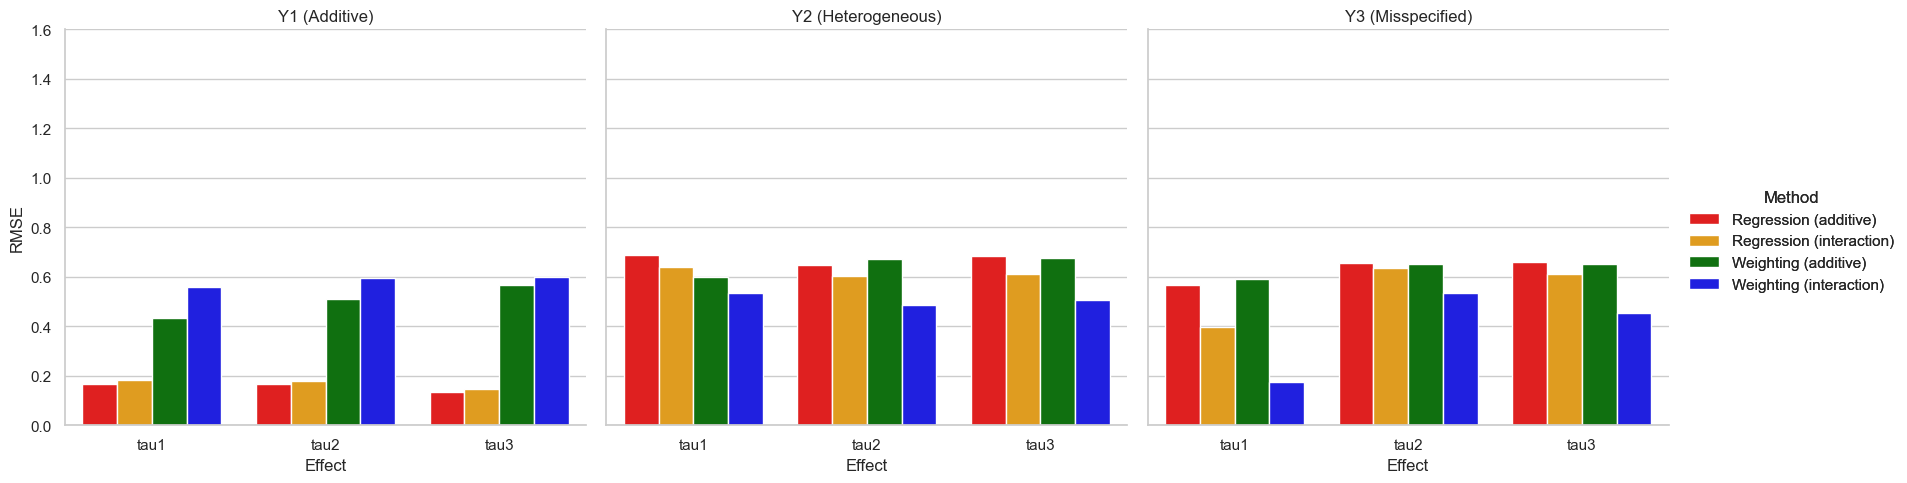

In [16]:
def plot_rmse_comparison_approx(results_dict):
    effects = ['tau1', 'tau2', 'tau3']
    models = {"additive": "Y1 (Additive)", "het": "Y2 (Heterogeneous)", "mis": "Y3 (Misspecified)"}
    
    data = []
    for model_type, rmse_vals in results_dict.items():
        for method, values in rmse_vals.items():
            for i, val in enumerate(values):
                data.append([models[model_type], effects[i], val, method])

    df = pd.DataFrame(data, columns=["Outcome Model", "Effect", "RMSE", "Method"])
    
    # Set style
    sns.set(style="whitegrid")

    # Create FacetGrid bar plot
    g = sns.catplot(
        data=df,
        x="Effect",
        y="RMSE",
        hue="Method",
        col="Outcome Model",
        kind="bar",
        palette=['red', 'orange', 'green', 'blue'],
        height=5,
        aspect=1
    )

    g.set_axis_labels("Effect", "RMSE")
    g.set_titles("{col_name}")
    g.set_xticklabels(rotation=0)
    g.add_legend(title="Method")
    g.set(ylim=(0, 0.65))
    
    plt.show()

results_dict = {}

results_dict = {
    "additive": {
        "Regression (additive)": [0.0071607, 0.00747884, 0.007182],
        "Regression (interaction)": [0.00749714, 0.00766074, 0.00729396],
        "Weighting (additive)": [0.00957313, 0.00908547, 0.00890573],
        "Weighting (interaction)": [0.00975002, 0.0091289, 0.00904973]
    },
    "het": {
        "Regression (additive)": [0.26884906, 0.44287349, 0.38333178],
        "Regression (interaction)": [0.60348814, 0.60412359, 0.6033029],
        "Weighting (additive)": [0.2865843, 0.32954693, 0.30674729],
        "Weighting (interaction)": [0.14881197, 0.14828785, 0.14750693]
    },
    "mis": {
        "Regression (additive)": [0.24024016, 0.42220238, 0.36515148],
        "Regression (interaction)": [0.34999569, 0.58785923, 0.58230781],
        "Weighting (additive)": [0.28078339, 0.31040218, 0.30997795],
        "Weighting (interaction)": [0.10361255, 0.1479375, 0.15812194]
    }
}

plot_rmse_comparison_approx(results_dict)